#Libraries and setup

In [ ]:
import os
import tensorflow as tf
import pathlib
import random
import matplotlib.pyplot as plt
import cv2
import imghdr

In [ ]:
!mkdir StatisticalMethodsForML_CNN
!mkdir StatisticalMethodsForML_CNN/Datasets
!mkdir StatisticalMethodsForML_CNN/Datasets/Original_dataset

In [ ]:
path_to_downloaded_file = tf.keras.utils.get_file(
    fname='/content/StatisticalMethodsForML_CNN/Datasets/Original_dataset/Original_dataset_zip',
    origin='https://unimibox.unimi.it/index.php/s/eNGYGSYmqynNMqF/download',
    cache_subdir='Original_dataset/',
    extract=True,
    cache_dir='/content/StatisticalMethodsForML_CNN/Datasets'
)

852271104/Unknown - 232s 0us/step

In [ ]:
!mv '/content/StatisticalMethodsForML_CNN/Datasets/Original_dataset/CatsDogs' '/content/StatisticalMethodsForML_CNN/Datasets/Original_dataset/Cats_and_dogs'

# Remove not valid or damaged images

In [ ]:
dataset_directory = '/content/StatisticalMethodsForML_CNN/Datasets/Original_dataset/Cats_and_dogs' 

DIM = 256
allowed_extensions = ['jpeg', 'jpg']

def clean_dataset():
  for image_class in os.listdir(dataset_directory):
    #image_path = os.path.joindata_dir, (image_class)
    for image in os.listdir(os.path.join(dataset_directory, image_class)):
      image_path = os.path.join(dataset_directory, image_class, image)
      print(image_path)
      try:
        image_file = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image_resizing = cv2.resize(image_file, (DIM, DIM))
        image_type = imghdr.what(image_path)
        if image_type not in allowed_extensions:
          print('Not jpeg image: ' + str(image_path))
          os.remove(image_path)
      except Exception as e:
        print('Corrupted image: ' + str(image_path))
        os.remove(image_path)
    
clean_dataset()

#Build dataset: read images, convert to grayscale and normalize

In [ ]:
path_to_dataset_directory = pathlib.Path('/content/StatisticalMethodsForML_CNN/Datasets/Original_dataset/Cats_and_dogs/')

images_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path_to_dataset_directory,
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
)

Found 24734 files belonging to 2 classes.


In [ ]:
to_grayscale_and_normalized_images_dataset = images_dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x) / 255, y))

#Scale down images

Images before scaling:



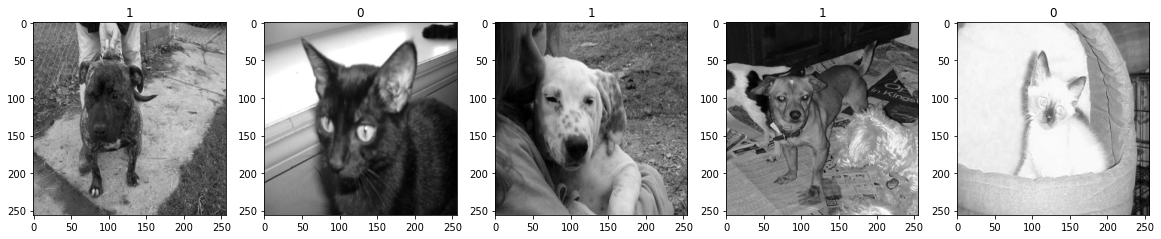


Images after scaling:



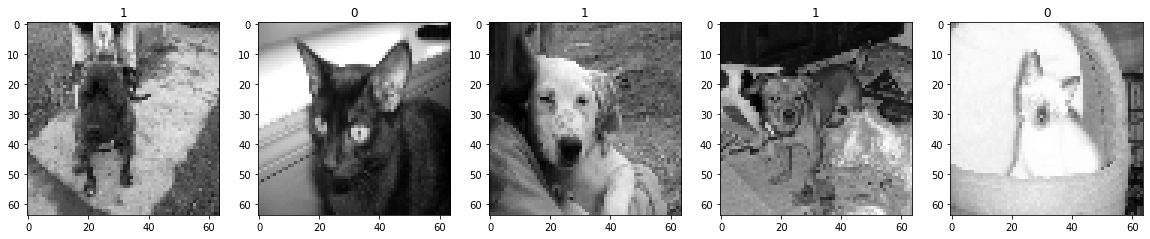

In [ ]:
NEW_SIZE = 64

dataset_samples = to_grayscale_and_normalized_images_dataset.take(5)
batches = list(dataset_samples.as_numpy_iterator())

print('Images before scaling:\n')

fig, ax = plt.subplots(ncols=len(batches), figsize=(20,20))
for immagine_idx in range(len(batches)):
  ax[immagine_idx].imshow(batches[immagine_idx][0][0,:,:,0], cmap='gray')
  ax[immagine_idx].title.set_text(str(batches[immagine_idx][1][0]))

plt.show()

print('\nImages after scaling:\n')

fig, ax = plt.subplots(ncols=len(batches), figsize=(20,20))
for immagine_idx in range(len(batches)):
  resized = tf.image.resize(batches[immagine_idx][0][0,:,:,:], (NEW_SIZE, NEW_SIZE))
  ax[immagine_idx].imshow(resized[:,:,0], cmap='gray')
  ax[immagine_idx].title.set_text(str(batches[immagine_idx][1][0]))

plt.show()

In [ ]:
scaled_down_images_dataset = to_grayscale_and_normalized_images_dataset.map(lambda x, y: (tf.image.resize(x, (NEW_SIZE, NEW_SIZE)), y))
#scaled_down_images_dataset.as_numpy_iterator().next()[0].shape
#len(scaled_down_images_dataset)

#Data augmentation

In [ ]:
randomly_right_or_left_flipped_images_dataset = scaled_down_images_dataset.map(lambda x, y: (tf.image.random_flip_left_right(x), y))

randomly_up_or_down_flipped_images_dataset = randomly_right_or_left_flipped_images_dataset.map(lambda x, y: (tf.image.random_flip_up_down(x), y))

half_dataset_size = int(len(randomly_up_or_down_flipped_images_dataset) / 2)

images_to_rotate = randomly_up_or_down_flipped_images_dataset.take(half_dataset_size)
randomly_rotated_images_dataset = images_to_rotate.map(lambda x, y: (tf.image.rot90(x, k=random.randint(0, 3)), y))

images_not_to_rotate = randomly_up_or_down_flipped_images_dataset.skip(half_dataset_size).take(half_dataset_size)
not_rotated_images_dataset = images_not_to_rotate

final_preprocessed_dataset = randomly_rotated_images_dataset.concatenate(not_rotated_images_dataset)

#len(final_preprocessed_dataset)

772

(32, 64, 64, 1)

Images after random flippings:



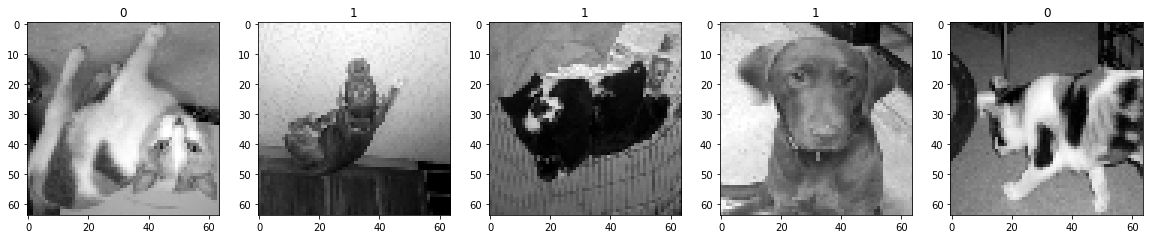

In [ ]:
dataset_samples = final_preprocessed_dataset.take(5)
#print(final_preprocessed_dataset.as_numpy_iterator().next()[0].shape)
#image_samples = final_preprocessed_dataset.as_numpy_iterator().next()
batches = list(dataset_samples.as_numpy_iterator())

print('\nImages after random flippings:\n')

fig, ax = plt.subplots(ncols=len(batches), figsize=(20,20))
for immagine_idx in range(len(batches)):
  resized = tf.image.resize(batches[immagine_idx][0][0,:,:,:], (NEW_SIZE, NEW_SIZE))
  ax[immagine_idx].imshow(resized[:,:,0], cmap='gray')
  ax[immagine_idx].title.set_text(str(batches[immagine_idx][1][0]))

plt.show()

#Split dataset into training and validation sets

In [ ]:
dataset_size = len(final_preprocessed_dataset)

shuffled_final_preprocessed_dataset = final_preprocessed_dataset.shuffle(dataset_size)

training_split = int(0.8 * dataset_size)
validation_split = int(0.2 * dataset_size)

training_set = shuffled_final_preprocessed_dataset.take(training_split)
validation_set = shuffled_final_preprocessed_dataset.skip(training_split).take(validation_split)

#training_set_lenght = len(training_set)
#training_set_lenght

#Generate 5-fold cross validation sets

In [ ]:
folds_number = 5
folds_size = int(len(training_set) / 5)
#print(folds_size)

training_sets = []
testing_sets = []

def generate_5_fold_cross_validation_sets():
  for i in range(folds_number):
    training_folds = []
    for j in range(folds_number):
      if (i == j):
        testing_sets.append(training_set.skip(i * folds_size).take(folds_size))
        #print(str(len(testing_sets[i])) + ' ' + str(i) + ' ' + str(j))
      elif (i != j):
        dataset = training_set.skip(j * folds_size).take(folds_size)
        training_folds.append(dataset)
    #print(str(len(training_folds)))

    training_set = training_folds[0]
    for t in range(len(training_folds) - 1):
      training_set = training_set.concatenate(training_folds[t + 1])
    #print(len(training_set))
    training_sets.append(training_set.shuffle(len(training_set)))

  #print(len(training_sets))
  #print(len(testing_sets))
  #print(len(training_sets[0]))
  #print(len(testing_sets[0]))

generate_5_fold_cross_validation_sets()

123
123


#Convolutional neural network architecture

In [ ]:
CNN = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(NEW_SIZE, NEW_SIZE, 1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), 1, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), 1, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

CNN.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0

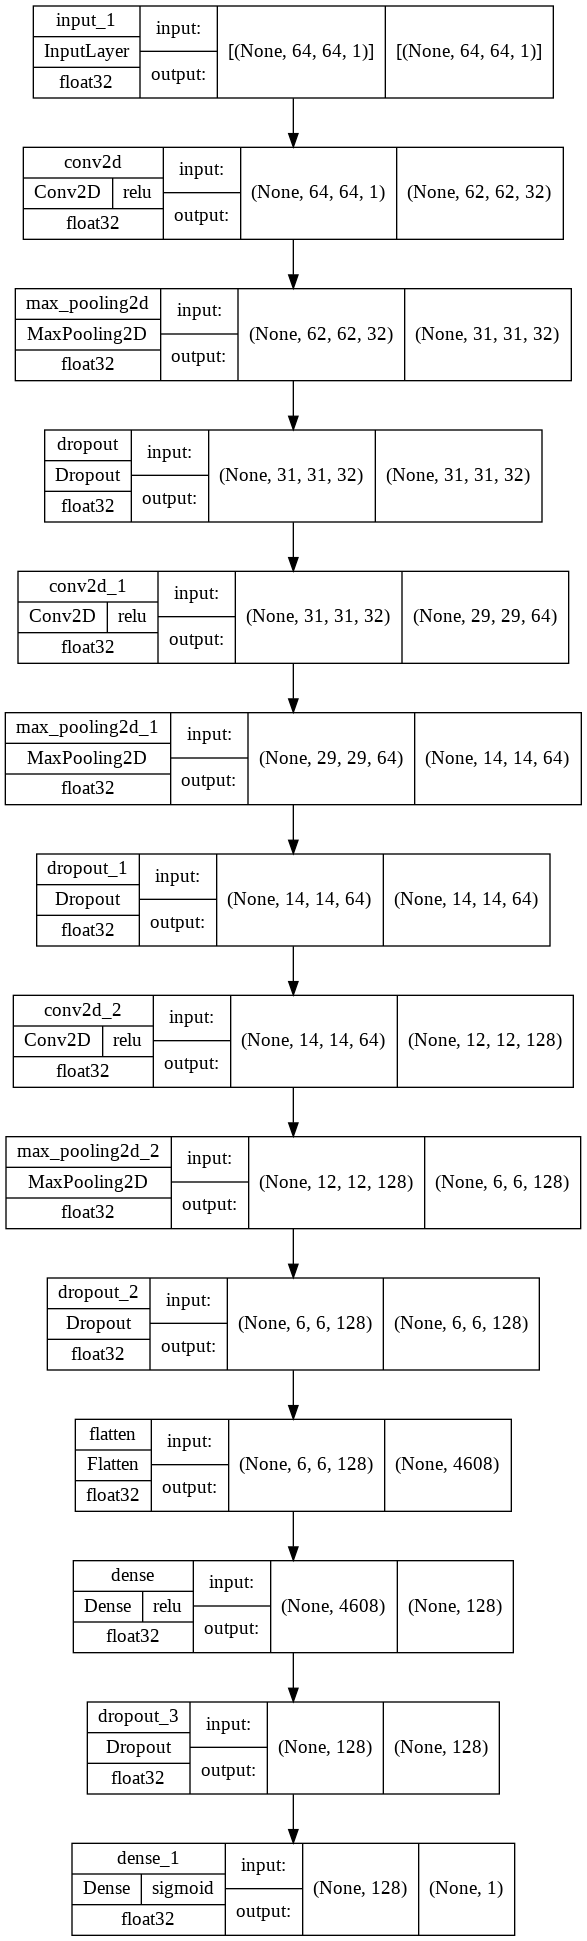

In [ ]:
tf.keras.utils.plot_model(
    CNN,
    to_file='CNN.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    dpi=96,
    show_layer_activations=True
)

#Training, validation and testing

In [ ]:
cnn_models = []

for i in range(5):
  model = CNN.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['binary_accuracy']
  )
  cnn_models.append(model)

#cnn_models

In [ ]:
cnn_models

all_5_fold_cross_validation_training_results = []
all_5_fold_cross_validation_test_results = []

def training_and_testing_with_5_fold_cross_validation(models, folds, training_folds_list, testing_folds_list, validation_dataset):
  for i in range(folds):
    tf.keras.backend.clear_session()

    nn_model_for_fold_i = models[i]
    print('\nStarting training on ' + str(i) + '-th fold\n')
    training_result = nn_model_for_fold_i.fit(
        training_folds_list[i],
        epochs=100,
        batch_size=32,
        validation_data=validation_dataset
    )
    all_5_fold_cross_validation_training_results.append(training_result)
    print('\nTraining on ' + str(i) + '-th fold finished\n')
    print('\nStarting testing on ' + str(i) + '-th fold\n')
    testing_result = nn_model_for_fold_i.evaluate(
        testing_folds_list[i],
        batch_size=32
    )
    all_5_fold_cross_validation_test_results.append(testing_result)
    print('\nTesting on ' + str(i) + '-th fold finished\n')

training_and_testing_with_5_fold_cross_validation(cnn_models, folds_number, training_sets, testing_sets, validation_set)